In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

import warnings
# 忽略所有警告，使 Notebook 輸出乾淨
warnings.filterwarnings('ignore')

# **新增：設定全局亂數種子**
SEED = 42 # 選擇任何數字都可以，但每次都要用同一個
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.settings.random_state = SEED # 設定 Scanpy 的亂數種子

# 載入 PBMC 3k 資料集
adata = sc.datasets.pbmc3k()
# 初始資料查看
print(adata)

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


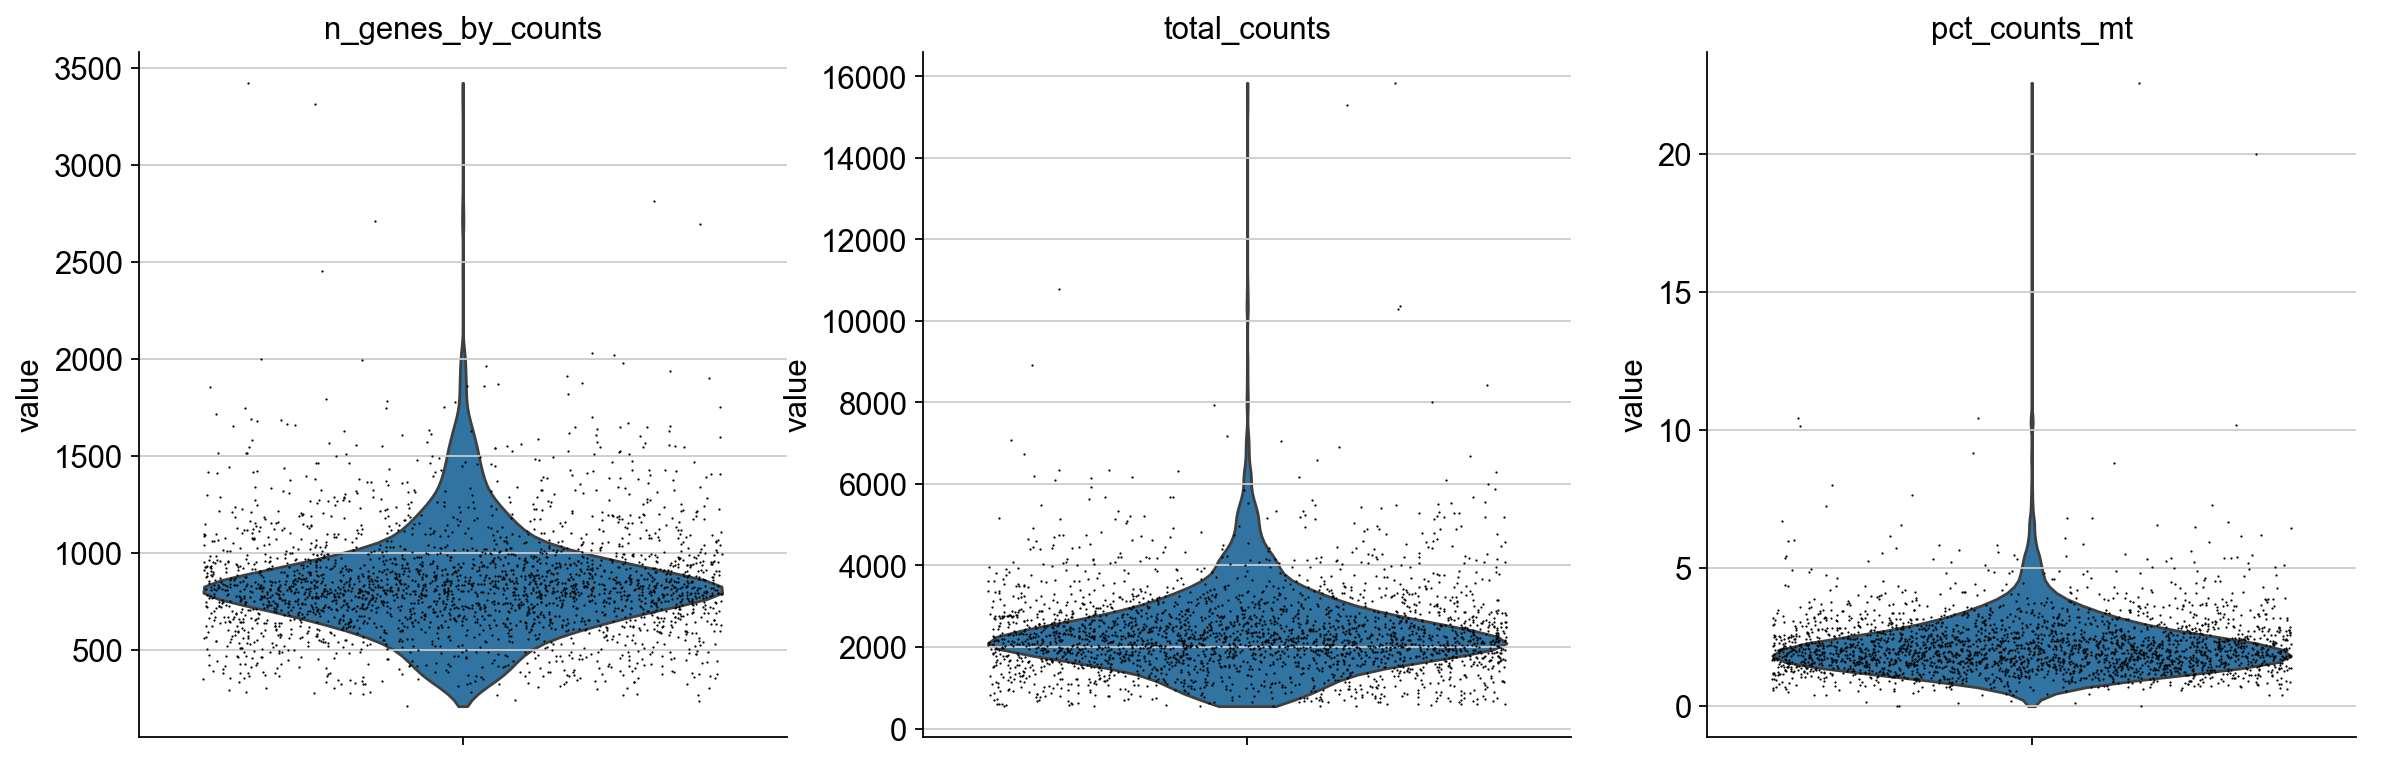

In [2]:
# 1. 計算粒線體基因比例 (假設 'MT-' 為粒線體基因前綴)
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# 2. 數據視覺化 (QC診斷圖) - 這一步是為了幫助您決定後續的過濾閾值
# 檢查：每個細胞的基因數量、總讀數、粒線體比例的分布
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, save='_qc_metrics_pre_filter.png')

In [3]:
# 3. 根據 QC 診斷結果，設定並執行過濾

# A. 過濾細胞 (Cells)
print(f"原始細胞數量: {adata.n_obs}")

# 1. 過濾粒線體比例過高的細胞 (選擇 < 5%)
adata = adata[adata.obs['pct_counts_mt'] < 5, :]

# 2. 過濾基因數量太少和太多的細胞 (選擇 > 200 且 < 2500)
# (注意：Python 的索引操作是 [行, 列]，所以我們對行(細胞)進行操作)
adata = adata[adata.obs['n_genes_by_counts'] > 200, :]
adata = adata[adata.obs['n_genes_by_counts'] < 2500, :]

print(f"過濾後剩餘細胞數量: {adata.n_obs}")
print("-" * 30)

# B. 過濾基因 (Genes)
# 過濾在少數細胞中才被偵測到的基因 (例如：在少於 3 個細胞中出現的基因)
sc.pp.filter_genes(adata, min_cells=3)

print(f"過濾後剩餘基因數量: {adata.n_vars}")

原始細胞數量: 2700
過濾後剩餘細胞數量: 2638
------------------------------
過濾後剩餘基因數量: 13656


In [4]:
# 4. 正規化 (Normalization) 與 Log 轉換

# 將每個細胞的讀數總量正規化到 10^4
sc.pp.normalize_total(adata, target_sum=1e4)

# 進行 Log 轉換，讓數據分佈更適合統計分析
sc.pp.log1p(adata)

# 5. 選擇高變異基因 (Highly Variable Genes, HVG)
# 找出在細胞間表達差異最大的基因，用於後續降維，大幅減少計算量
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

print(f"總基因數量: {adata.n_vars}")
print(f"高變異基因數量: {sum(adata.var['highly_variable'])}")

# *** 新增：將 Log 轉換後的數據備份到 .raw 屬性中 ***
adata.raw = adata

# 6. 過濾為僅包含高變異基因 (確保只使用最相關的特徵)
adata = adata[:, adata.var.highly_variable]

# 7. 數據縮放 (Scaling)
# 將基因表現值縮放到標準差為 1，讓不同基因之間可比
sc.pp.scale(adata, max_value=10)

print("-" * 30)
print("正規化與 HVG 選擇完成。準備進行 PCA 降維。")

總基因數量: 13656
高變異基因數量: 1826
------------------------------
正規化與 HVG 選擇完成。準備進行 PCA 降維。


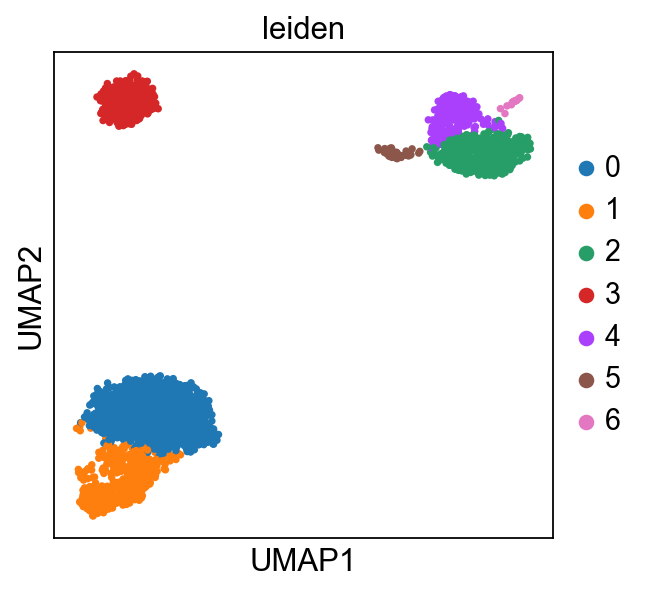

In [5]:
# 8. PCA 降維 
sc.pp.pca(adata, n_comps=50)

# 9. 建立細胞鄰居圖 
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

# 10. Leiden 分群
# *** 修改：加入 random_state=SEED ***
sc.tl.leiden(adata, random_state=SEED)

# 11. UMAP 降維與視覺化
# *** 修改：加入 random_state=SEED ***
sc.tl.umap(adata, random_state=SEED)

# 繪圖
sc.pl.umap(adata, color='leiden', save='_pbmc_clustering_v2.png')

In [6]:
# 將處理好的 adata 物件儲存為 .h5ad 檔案
# 這是 Scanpy/AnnData 專用的高效儲存格式

adata.write('pbmc_processed_for_ml.h5ad')

print("已將處理好的數據儲存為 pbmc_processed_for_ml.h5ad")

已將處理好的數據儲存為 pbmc_processed_for_ml.h5ad
